In [125]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from flash_ansr import get_path

In [2]:
ids = {
    'v6.0': '9r0lhfh5',
    'v6.1': '4hff7ng2',
    'v6.2': 'v98t9bok',
    'v6.3': '5hx1ve2m',
    'v6.4': 'govhlcbi',
    'v6.6': 'yimrgxy0',
}

In [3]:
runs = {}
histories = {}
for version, run_id in ids.items():
    api = wandb.Api()
    run = api.run(f'psaegert/neural-symbolic-regression/{run_id}')
    runs[version] = run
    histories[version] = [x for x in tqdm(run.scan_history(page_size=100000), total=run.summary['_step'], desc=version)]

v6.0: 1500001it [01:38, 15231.31it/s]                             
v6.1: 1500001it [01:38, 15275.90it/s]                             
v6.2: 1500001it [01:38, 15267.53it/s]                             
v6.3: 1500001it [01:42, 14635.04it/s]                             
v6.4: 1500001it [01:40, 14989.50it/s]                             
v6.6: 1500001it [01:39, 15033.62it/s]                             


In [4]:
data = {}
for version, history in histories.items():
    keys = history[0].keys()
    data[version] = {k: np.array([x[k] for x in history]).astype(float) for k in tqdm(keys, desc=version)}

val_data = {}
for version, d in data.items():
    valid_val_mask = ~np.isnan(d['val_ce_loss'])  # Only includes validation steps where the loss is available
    val_data[version] = {k: v[valid_val_mask] for k, v in d.items()}

v6.6: 100%|██████████| 27/27 [00:06<00:00,  4.38it/s]


In [ ]:
def smooth_w_boundaries(x, window_len=101):
    if window_len % 2 == 0:
        window_len += 1

    if window_len < 3:
        return x

    kernel = np.hanning(window_len)
    kernel /= kernel.sum()

    # Convolve the middle part with valid mode
    x_convolved_middle = np.convolve(x, kernel, mode='valid')

    # Convolve the left and right boundaries such that only overlapping part of the kernel is used
    half_window = window_len // 2
    x_convolved_left = np.empty(2 * half_window - 1)
    x_convolved_right = np.empty(2 * half_window - 1)
    for i in range(1, 2 * half_window):
        x_convolved_left[i - 1] = x[:i] @ kernel[-i:] / kernel[-i:].sum()
        x_convolved_right[i - 1] = x[- 2 * half_window + i:] @ kernel[:2 * half_window - i] / kernel[:2 * half_window - i].sum()

    # Concatenate the left, middle and
    x_convolved = np.concatenate((x_convolved_left[half_window - 1:], x_convolved_middle, x_convolved_right[:half_window]))

    return x_convolved

In [32]:
smoothed_data = {}
for version, history in histories.items():
    smoothed_data[version] = {k: smooth_w_boundaries(v, 1001) for k, v in tqdm(data[version].items(), desc=version)}

/tmp/ipykernel_14894/3202860526.py:16: RuntimeWarning: invalid value encountered in scalar divide
  x_convolved_left[i - 1] = x[:i] @ kernel[-i:] / kernel[-i:].sum()
/tmp/ipykernel_14894/3202860526.py:17: RuntimeWarning: invalid value encountered in scalar divide
  x_convolved_right[i - 1] = x[- 2 * half_window + i:] @ kernel[:2 * half_window - i] / kernel[:2 * half_window - i].sum()
v6.6: 100%|██████████| 27/27 [00:02<00:00,  9.38it/s]


In [63]:
smoothed_val_data = {}
for version, history in histories.items():
    smoothed_val_data[version] = {k: smooth_w_boundaries(v, 9) for k, v in tqdm(val_data[version].items(), desc=version)}

/tmp/ipykernel_14894/3202860526.py:16: RuntimeWarning: invalid value encountered in scalar divide
  x_convolved_left[i - 1] = x[:i] @ kernel[-i:] / kernel[-i:].sum()
/tmp/ipykernel_14894/3202860526.py:17: RuntimeWarning: invalid value encountered in scalar divide
  x_convolved_right[i - 1] = x[- 2 * half_window + i:] @ kernel[:2 * half_window - i] / kernel[:2 * half_window - i].sum()
v6.6: 100%|██████████| 27/27 [00:00<00:00, 28003.51it/s]


In [100]:
def int_to_post(x):
    if x < 1000:
        return str(x)
    if x < 1e6:
        if x % 1000 == 0:
            return f'{int(x // 1000)}k'
        return f'{x // 1000:.1f}k'
    if x < 1e9:
        if x % 1e6 == 0:
            return f'{int(x // 1e6)}M'
        return f'{x / 1e6:.1f}M'

    if x % 1e9 == 0:
        return f'{int(x // 1e9)}B'
    return f'{x / 1e9:.1f}B'

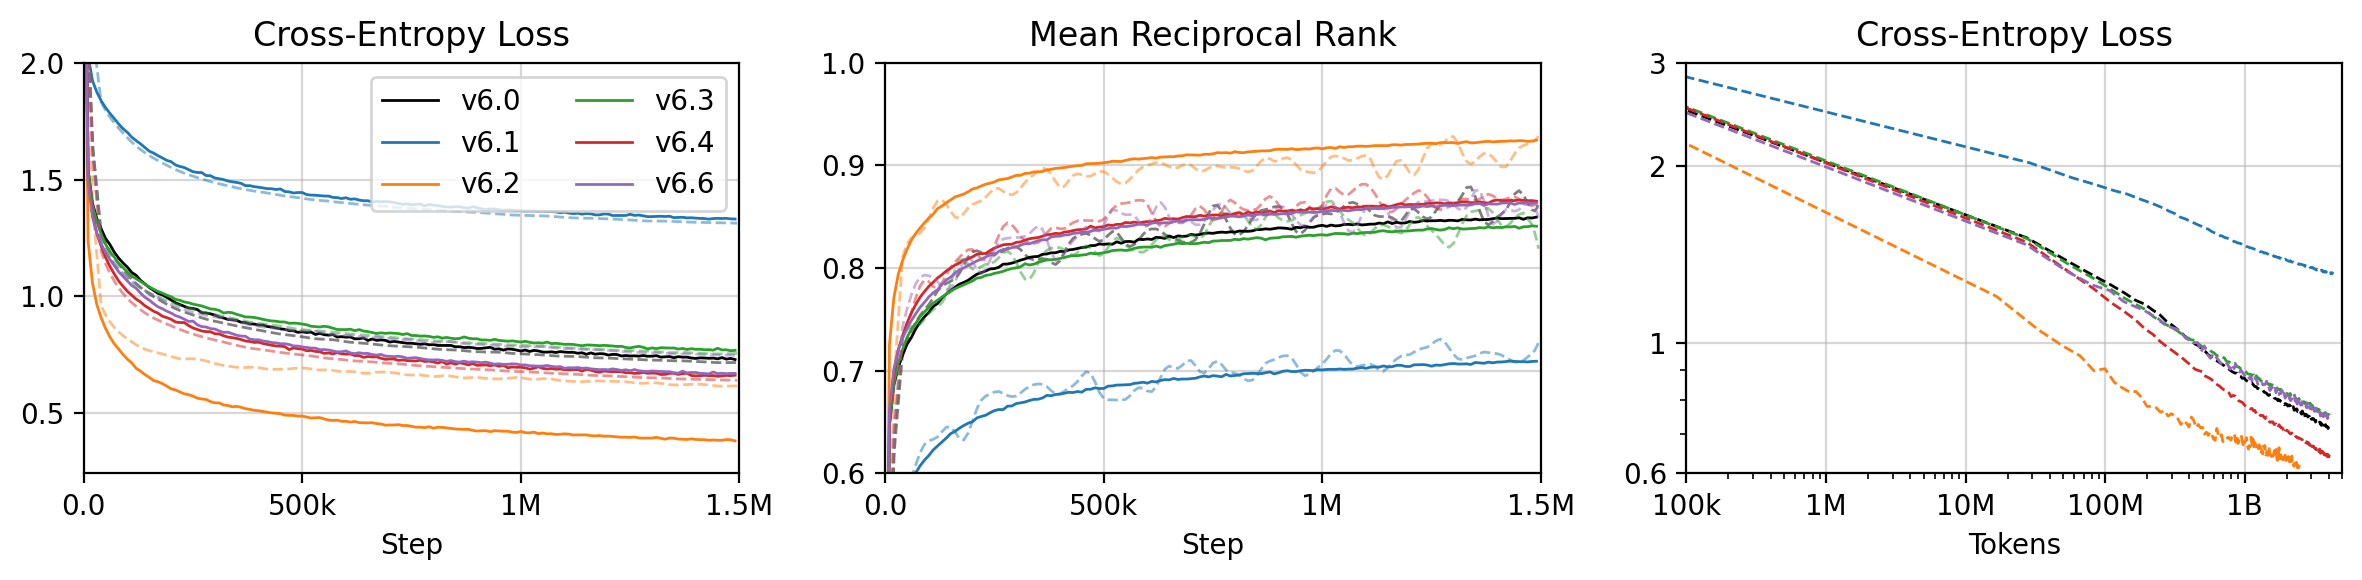

In [126]:
x_list = ['_step', '_step', 'cumulative_training_tokens']
y_list = [['train_ce_loss', 'val_ce_loss'], ['train_mean_reciprocal_rank', 'val_mean_reciprocal_rank'], ['val_ce_loss']]
xlabel_list = ['Step', 'Step', 'Tokens']
title_list = ['Cross-Entropy Loss', 'Mean Reciprocal Rank', 'Cross-Entropy Loss']
xlim_list = [(0, 1.5e6), (0, 1.5e6), (1e5, 5e9)]
ylim_list = [(None, 2), (0.6, 1), (0.6, 3)]
xscale_list = ['linear', 'linear', 'log']
yscale_list = ['linear', 'linear', 'log']
use_smoothed_list = [True, True, False]
xticks_list = [np.linspace(0, 1.5e6, 4), np.linspace(0, 1.5e6, 4), np.logspace(5, 9, 5)]
xticklabels_list = [list(map(int_to_post, xticks)) for xticks in xticks_list]
yticks_list = [None, None, [0.6, 1, 2, 3]]
yticklabels_list = [None, None, [0.6, 1, 2, 3]]

COLS = 3
ROWS = np.ceil(len(x_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(4 * COLS, 3 * ROWS), dpi=200)
axes = axes.flatten()

for i, (x, ys, xlim, ylim, x_scale, y_scale, use_smoothed, xticks, xticklabels, yticks, yticklabels, xlabel, title) in enumerate(zip(x_list, y_list, xlim_list, ylim_list, xscale_list, yscale_list, use_smoothed_list, xticks_list, xticklabels_list, yticks_list, yticklabels_list, xlabel_list, title_list)):
    for j, (version, smoothed_data_item) in enumerate(smoothed_data.items()):
        ax = axes[i]

        for y in ys:
            if use_smoothed:
                plot_data_x = smoothed_data[version][x] if 'train' in y else smoothed_val_data[version][x]
                plot_data_y = smoothed_data[version][y] if 'train' in y else smoothed_val_data[version][y]
            else:
                plot_data_x = data[version][x] if 'train' in y else val_data[version][x]
                plot_data_y = data[version][y] if 'train' in y else val_data[version][y]

            style = '-' if 'train' in y else '--'
            plot_every = 10000 if 'train' in y else 1

            ax.plot(plot_data_x[::plot_every], plot_data_y[::plot_every], style, label=version if 'train' in y else None, color=f'C{j-1}' if j > 0 else 'k', zorder=2, linewidth=1, alpha=0.5 if 'val' in y and any('train' in y for y in ys) else 1)

    ax.set_xscale(x_scale)
    ax.set_yscale(y_scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.5, zorder=1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    if yticks is not None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
        
axes[0].legend(ncol=2, loc='upper right')

fig.tight_layout()

plt.savefig(get_path('results', 'wandb', create=True, filename='wandb_train_histories.svg'))